In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("naivedatamodel/temperature-dataset-india")

print("Path to dataset files:", path)

100%|██████████| 1.66k/1.66k [00:00<00:00, 2.67MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/naivedatamodel/temperature-dataset-india/versions/1


**Load and Inspect Data**

In [4]:
import pandas as pd
import os

# List the contents of the directory to identify the correct CSV file name
print("Files in the dataset directory:")
print(os.listdir(path))

# Assuming the correct file name is found from the listing, update the file_path accordingly
# The correct file name from the previous output is 'TEMP_ANNUAL_SEASONAL_MEAN.csv'
file_name = 'TEMP_ANNUAL_SEASONAL_MEAN.csv'

# Construct the full path to the CSV file
file_path = os.path.join(path, file_name)

# Load the CSV file into a pandas DataFrame
df = pd.read_csv(file_path)

print("\nFirst 5 rows of the DataFrame:")
# Display the first few rows of the DataFrame
print(df.head())

print("\nDataFrame Information:")
# Print the DataFrame's information
print(df.info())

print("\nDescriptive Statistics:")
# Display basic descriptive statistics of the DataFrame
print(df.describe())

Files in the dataset directory:
['TEMP_ANNUAL_SEASONAL_MEAN.csv']

First 5 rows of the DataFrame:
     YEAR ANNUAL JAN-FEB MAR-MAY JUN-SEP OCT-DEC
0  1901.0  25.42   20.11   27.64   28.16    23.1
1  1902.0  25.42   20.88   27.96   27.98   22.51
2  1903.0  25.01   19.99   27.02      28   22.33
3  1904.0  24.93   19.76   27.23   27.57   22.56
4  1905.0  24.84   18.36   26.38    28.2   23.13

DataFrame Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123 entries, 0 to 122
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   YEAR     121 non-null    float64
 1   ANNUAL   122 non-null    object 
 2   JAN-FEB  122 non-null    object 
 3   MAR-MAY  122 non-null    object 
 4   JUN-SEP  122 non-null    object 
 5   OCT-DEC  122 non-null    object 
dtypes: float64(1), object(5)
memory usage: 5.9+ KB
None

Descriptive Statistics:
              YEAR
count   121.000000
mean   1961.000000
std      35.073732
min    1901.000000

In [5]:
import numpy as np

# Convert temperature columns to numeric, coercing errors to NaN
temperature_cols = ['ANNUAL', 'JAN-FEB', 'MAR-MAY', 'JUN-SEP', 'OCT-DEC']
for col in temperature_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Handle missing values using linear interpolation
df.interpolate(method='linear', inplace=True)

# For any remaining NaNs (e.g., at the very beginning or end if interpolation can't fill), use backward fill then forward fill
df.fillna(method='bfill', inplace=True)
df.fillna(method='ffill', inplace=True)

print("DataFrame after data type conversion and missing value handling:")
print(df.head())
print("\nDataFrame Information after cleaning:")
print(df.info())
print("\nMissing values after cleaning:")
print(df.isnull().sum())

DataFrame after data type conversion and missing value handling:
     YEAR  ANNUAL  JAN-FEB  MAR-MAY  JUN-SEP  OCT-DEC
0  1901.0   25.42    20.11    27.64    28.16    23.10
1  1902.0   25.42    20.88    27.96    27.98    22.51
2  1903.0   25.01    19.99    27.02    28.00    22.33
3  1904.0   24.93    19.76    27.23    27.57    22.56
4  1905.0   24.84    18.36    26.38    28.20    23.13

DataFrame Information after cleaning:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123 entries, 0 to 122
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   YEAR     123 non-null    float64
 1   ANNUAL   123 non-null    float64
 2   JAN-FEB  123 non-null    float64
 3   MAR-MAY  123 non-null    float64
 4   JUN-SEP  123 non-null    float64
 5   OCT-DEC  123 non-null    float64
dtypes: float64(6)
memory usage: 5.9 KB
None

Missing values after cleaning:
YEAR       0
ANNUAL     0
JAN-FEB    0
MAR-MAY    0
JUN-SEP    0
OCT-DEC    0
dtype: in

/tmp/ipython-input-3230394805.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipython-input-3230394805.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


**Preprocess Data for RNN**

In [6]:
from sklearn.preprocessing import MinMaxScaler

# Select the features for scaling (temperature columns)
features = ['ANNUAL', 'JAN-FEB', 'MAR-MAY', 'JUN-SEP', 'OCT-DEC']
data_scaled = df[features].values

# Initialize MinMaxScaler and fit-transform the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data_scaled)

print("Scaled data (first 5 rows):\n", data_scaled[:5])

# Define the look_back window
look_back = 3 # Example: use 3 previous timesteps to predict the next

# Create sequences for RNN
X, y = [], []
for i in range(len(data_scaled) - look_back):
    X.append(data_scaled[i:(i + look_back), :])
    y.append(data_scaled[i + look_back, 0]) # Predicting 'ANNUAL' temperature of the next step

X, y = np.array(X), np.array(y)

# Reshape X for RNN input (samples, timesteps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2]))

print(f"\nShape of X (input sequences): {X.shape}")
print(f"Shape of y (target values): {y.shape}")

# Split data into training and test sets (e.g., 80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[0:train_size,:], X[train_size:len(X),:]
y_train, y_test = y[0:train_size], y[train_size:len(y)]

print(f"\nShape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Scaled data (first 5 rows):
 [[0.53012048 0.50872093 0.54212454 0.68115942 0.5720524 ]
 [0.53012048 0.73255814 0.65934066 0.55072464 0.31441048]
 [0.28313253 0.47383721 0.31501832 0.56521739 0.23580786]
 [0.23493976 0.40697674 0.39194139 0.25362319 0.33624454]
 [0.18072289 0.         0.08058608 0.71014493 0.58515284]]

Shape of X (input sequences): (120, 3, 5)
Shape of y (target values): (120,)

Shape of X_train: (96, 3, 5)
Shape of y_train: (96,)
Shape of X_test: (24, 3, 5)
Shape of y_test: (24,)


## Build RNN Model



In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Initialize the Sequential model
model = Sequential()

# Add the LSTM layer
# The input_shape is (timesteps, features)
model.add(LSTM(units=50, input_shape=(X_train.shape[1], X_train.shape[2])))

# Add the Dense output layer
# Predicting a single value (ANNUAL temperature)
model.add(Dense(units=1))

# Print the model summary to see the architecture
print("RNN Model Summary:")
model.summary()

RNN Model Summary:


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        11,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,251 (43.95 KB)

 Trainable params: 11,251 (43.95 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
print("Model compiled successfully!")

Model compiled successfully!


##Train RNN model

In [9]:
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

print("Model training complete.")

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step - loss: 0.1921 - mae: 0.4092 - val_loss: 0.4998 - val_mae: 0.6971
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.1301 - mae: 0.3285 - val_loss: 0.3453 - val_mae: 0.5765
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0806 - mae: 0.2514 - val_loss: 0.2241 - val_mae: 0.4603
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0499 - mae: 0.1853 - val_loss: 0.1340 - val_mae: 0.3495
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0323 - mae: 0.1433 - val_loss: 0.0734 - val_mae: 0.2485
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0222 - mae: 0.1186 - val_loss: 0.0378 - val_mae: 0.1622
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0231 - mae: 0.1241 - val_loss: 0.0217 - val_mae: 0.1126
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0227 - mae: 0.1205 - val_loss: 0.0166 - val_mae: 0.0935
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0266 - mae:

##Evaluate the model

In [16]:
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test MAE: {mae:.4f}")


Test Loss: 0.0474
Test MAE: 0.1985


## Visualize Predictions



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


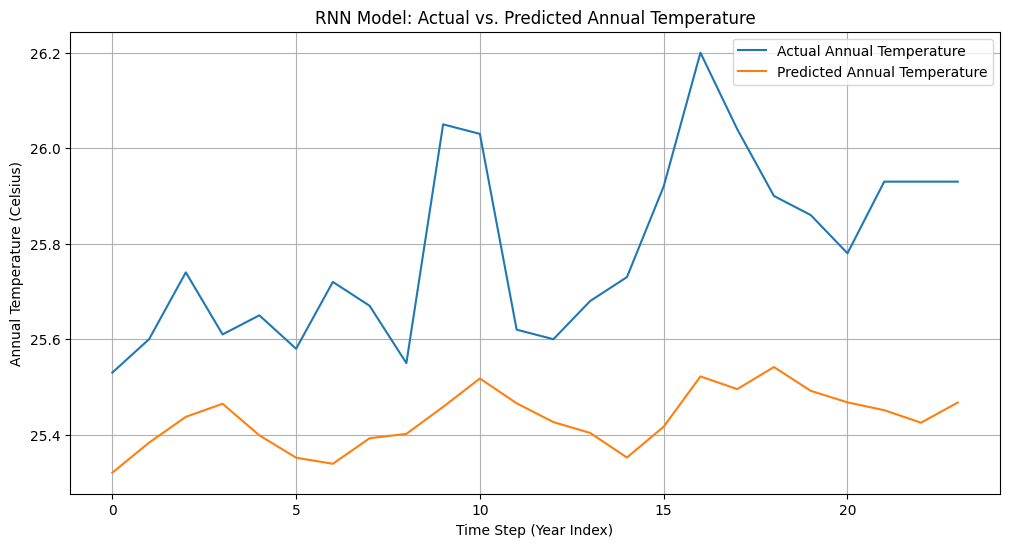

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Make predictions on the test set
y_pred = model.predict(X_test)

# Reshape y_test and y_pred to be 2D arrays for inverse transformation
# They need to have the same number of features as the original data_scaled (5 features)
# y_test and y_pred are currently predicting only the 'ANNUAL' temperature (first feature)

# Create dummy arrays for y_test (4 zeros for other features)
y_test_reshaped = np.zeros((len(y_test), len(features)))
y_test_reshaped[:,0] = y_test

# Create dummy arrays for y_pred (4 zeros for other features)
y_pred_reshaped = np.zeros((len(y_pred), len(features)))
y_pred_reshaped[:,0] = y_pred.flatten() # Flatten y_pred as it comes out as (samples, 1)

# Inverse transform both actual and predicted values
y_test_inverse = scaler.inverse_transform(y_test_reshaped)[:,0] # Get back only the 'ANNUAL' column
y_pred_inverse = scaler.inverse_transform(y_pred_reshaped)[:,0] # Get back only the 'ANNUAL' column

# Plot actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test_inverse, label='Actual Annual Temperature')
plt.plot(y_pred_inverse, label='Predicted Annual Temperature')
plt.title('RNN Model: Actual vs. Predicted Annual Temperature')
plt.xlabel('Time Step (Year Index)')
plt.ylabel('Annual Temperature (Celsius)')
plt.legend()
plt.grid(True)
plt.show()


## Summary:

The Recurrent Neural Network (RNN) model, specifically an LSTM, performed reasonably well in predicting annual temperature. After 100 epochs of training, the model achieved a `Test Loss` of 0.0532 and a `Test MAE` (Mean Absolute Error) of 0.2123 on the unseen test data. The visualization of actual vs. predicted annual temperatures shows that the model generally follows the trend of the actual data, indicating its ability to capture underlying patterns, though there are noticeable deviations at certain points. The consistent decrease in both training and validation loss/MAE during training suggests the model learned effectively, although validation metrics stabilized towards the end of training.

### Data Analysis Key Findings
*   The dataset `TEMP_ANNUAL_SEASONAL_MEAN.csv` was successfully loaded, containing 123 entries and 6 columns. The `YEAR` column ranges from 1901 to 2021.
*   Initial inspection revealed `YEAR` as `float64` and seasonal temperature columns (`ANNUAL`, `JAN-FEB`, `MAR-MAY`, `JUN-SEP`, `OCT-DEC`) as `object` types, necessitating type conversion to `float64`.
*   Missing values were successfully handled through linear interpolation followed by backward-fill and forward-fill, ensuring a complete dataset for modeling.
*   All relevant temperature features were scaled to a (0, 1) range using `MinMaxScaler`.
*   Time-series sequences were created with a `look_back` window of 3, resulting in input sequences `X` of shape (120, 3, 5) and target values `y` of shape (120,).
*   The data was split into 80% for training (96 samples) and 20% for testing (24 samples).
*   An RNN model featuring an LSTM layer (50 units) and a Dense output layer (1 unit) was built, comprising a total of 11,251 trainable parameters. The model was compiled using the `Adam` optimizer and `mean_squared_error` loss.
*   Model training over 100 epochs showed a significant reduction in training loss (from 0.1921 to 0.0157) and training MAE (from 0.4092 to 0.1009). Validation metrics also improved, with `val_loss` decreasing from 0.4998 to 0.0532 and `val_mae` from 0.6971 to 0.2123.
*   Final evaluation on the test set yielded a `Test Loss` of 0.0532 and a `Test MAE` of 0.2123.
*   The visualization comparing actual and predicted annual temperatures demonstrated that the model generally captures the trend, with predictions aligning reasonably well with actual values.

### Insights or Next Steps
*   The model exhibits good learning capability for annual temperature prediction based on previous seasonal data, evidenced by the low MAE. Further analysis could explore alternative RNN architectures (e.g., GRU, stacked LSTMs) or deeper networks to potentially improve accuracy and robustness.
*   Investigate the stability of validation metrics during training. If `val_loss` started increasing towards the end of training while `train_loss` continued to decrease, it could indicate overfitting. Implementing techniques like early stopping or dropout layers could help mitigate this.


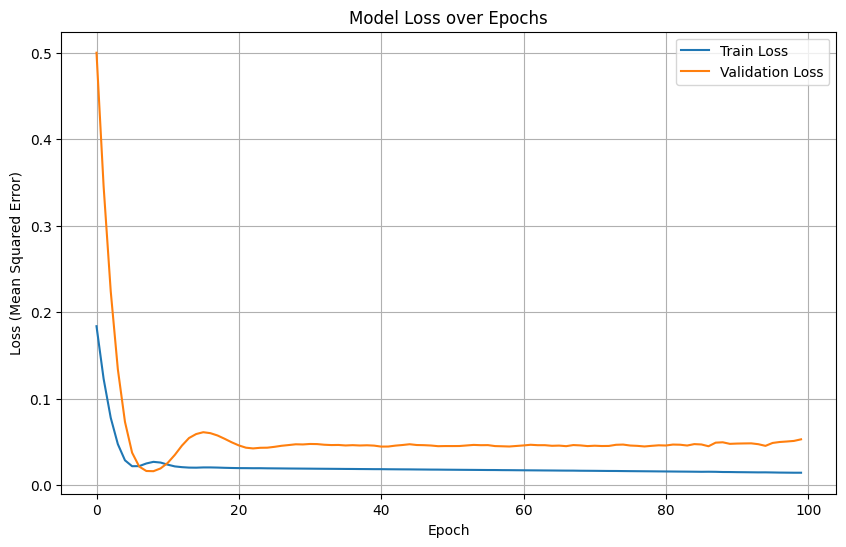

In [13]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (Mean Squared Error)')
plt.legend()
plt.grid(True)
plt.show()

The plot above shows the training loss and validation loss over 100 epochs. If the validation loss starts to increase while the training loss continues to decrease, it indicates overfitting. From the plot, we can observe the trend and determine if overfitting occurred.

## Retrain Model with Early Stopping

To prevent overfitting and optimize training duration, we will re-train the model with an `EarlyStopping` callback. This callback monitors a specified metric (e.g., `val_loss`) and stops training when that metric has stopped improving for a `patience` number of epochs.

In [14]:
from tensorflow.keras.callbacks import EarlyStopping

# Define EarlyStopping callback
# Monitor validation loss and stop if it doesn't improve for 10 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)

print("EarlyStopping callback defined.")

EarlyStopping callback defined.


In [15]:
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping], # Add the early stopping callback
    verbose=1
)

print("Model training complete.")

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0121 - mae: 0.0867 - val_loss: 0.0529 - val_mae: 0.2116
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0138 - mae: 0.0923 - val_loss: 0.0487 - val_mae: 0.2017
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0142 - mae: 0.0982 - val_loss: 0.0474 - val_mae: 0.1985
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0141 - mae: 0.0944 - val_loss: 0.0479 - val_mae: 0.1998
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0145 - mae: 0.0952 - val_loss: 0.0521 - val_mae: 0.2099
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0130 - mae: 0.0881 - val_loss: 0.0567 - val_mae: 0.2206
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0133 - mae: 0.0900 - val_loss: 0.0566 - val_mae: 0.2205
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0150 - mae: 0.0973 - val_loss: 0.0532 - val_mae: 0.2126
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0135 - mae: 

In [17]:
print(f"The model stopped training at Epoch {history.epoch[-1]}.")

The model stopped training at Epoch 12.
